### Intro:

The data describing the flow of patients in ED is given in test_data.txt. We first, import the data, then perform necessary 
processing. Next, we look at data summary.

In the next sections, answers to each question is provided.

Finally, some conculsions are made based on interpretations of data.

In [379]:
# import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import numpy as np
from datetime import timedelta
import warnings


In [380]:
# import data into a pandas dataframe

df = pd.read_csv('test_data.txt')


    Columns:
    1. visit_num: Row identifier for the patient visit 
    2. phys_name: Physician 
    3. shiftid: String variable denoting the date and beginning and end times of the physician’s shift.
    4. ed_tc: Date and time of patient arrival to ED 
    5. dcord_tc: Date and time of patient discharge order 
    6. xb_lntdc: Measure of expected log length of stay or “patient severity” 


In [381]:
# take a look at the first few lines:
df.head()

,ed_tc,dcord_tc,xb_lntdc,shiftid,phys_name,visit_num
0,17may1982 14:47:00,18may1982 10:49:00,0.408644,17may1982 1 p.m. to 10 p.m.,Andrew,1
1,14jul1982 17:49:00,14jul1982 18:51:00,0.338402,14jul1982 1 p.m. to 10 p.m.,Andrew,2
2,30jun1982 13:02:00,30jun1982 14:09:00,0.309749,30jun1982 11 a.m. to 8 p.m.,Andrew,3
3,21may1982 10:51:00,22may1982 10:11:00,0.592807,21may1982 6 a.m. to 4 p.m.,Andrew,4
4,21may1982 08:18:00,21may1982 09:02:00,1.174824,21may1982 6 a.m. to 4 p.m.,Andrew,5


In [382]:
# make sure there are no null values
df.isnull().values.any()

False

#### Data Processing:

This section includes transforming patient's arrival and discharge dates into datetime data type, creating and transforming start and end of shifts based off shiftid column, and adjusting shift_end date in cases where it rolls over the next day.

In [383]:
# data processing


# Trun off warnings
warnings.filterwarnings('ignore')

# change the month name to month number

df.groupby(df['ed_tc'].str.slice(2, 5)).sum()
# There is only 3 months in this column. We need to replace these monthnames with the corresponding number

df['ed_tc'] = df['ed_tc'].str[:2] + '-' + df['ed_tc'].str.slice(2, 5).replace({'may':'05', 'jun':'06', 'jul':'07'})+ '-' + df['ed_tc'].str[5:]

# convert to datetime for convenience
df['ed_tc'] = pd.to_datetime(df['ed_tc'], format = "%d-%m-%Y %H:%M:%S")

# same process for dcord_tc
df['dcord_tc'] = df['dcord_tc'].str[:2] + '-' + df['dcord_tc'].str.slice(2, 5).replace({'may':'05', 'jun':'06', 'jul':'07'})+ '-' + df['dcord_tc'].str[5:]
df['dcord_tc'] = pd.to_datetime(df['dcord_tc'], format = "%d-%m-%Y %H:%M:%S")

# convert shiftid to use month number 
temp = df['shiftid'].str[:2] + '-' + df['shiftid'].str.slice(2, 5).replace({'may':'05', 'jun':'06', 'jul':'07'})+ '-' + df['shiftid'].str[5:]

# now create shift_start and shift_end based off temp
df['shift_start'] = temp.str.split('to').str[0]
df['shift_end'] = temp.str.split(' ').str[0] + temp.str.split('to').str[1]

# now, change p.m. and a.m. to pm and am so to_datetime recognizes it
df['shift_start'] = df['shift_start'].str.replace('p.m.', 'PM')
df['shift_start'] = df['shift_start'].str.replace('a.m.', 'AM')
# change noon to 12 PM so it can be processed by to_datetime function
df['shift_start'] = df['shift_start'].str.replace('noon', '12 PM')
# remove extra space
df['shift_start'] = df['shift_start'].str.strip()

# same thing for shift_end
df['shift_end'] = df['shift_end'].str.replace('p.m.', 'PM')
df['shift_end'] = df['shift_end'].str.replace('a.m.', 'AM')
df['shift_end'] = df['shift_end'].str.replace('noon', '12 PM')
df['shift_end'] = df['shift_end'].str.strip()

# now, convert to datetime
df['shift_start'] = pd.to_datetime( df['shift_start'] , format = "%d-%m-%Y %I %p")
df['shift_end'] = pd.to_datetime( df['shift_end'] , format = "%d-%m-%Y %I %p")


In [384]:
# how long are the shifts?
df.groupby(df['shift_end']  - df['shift_start']).size()
# the first row with -1 day and +9 hours indicates that we need to adjust the shift_end day number

-1 days +09:00:00    1067
02:00:00                4
07:00:00               17
09:00:00             6772
10:00:00              971
dtype: int64

In [385]:
# take a look at shift_end
df.groupby(df['shift_end'].dt.time).size()
df.groupby(df['shift_start'].dt.time).size()

shift_start
03:00:00    1827
04:00:00     745
06:00:00     366
08:00:00    1746
10:00:00      17
11:00:00    1038
12:00:00     302
13:00:00    1723
19:00:00    1067
dtype: int64

In [386]:
# Shifts are usually 9-hour long. So if a shift starts after 15:00:00, 
# we need to increment shift_end by one day. 1067 shifts start at 19:00:00
# Do not run more than once!!
df.loc[df['shift_start'].dt.time > df['shift_end'].dt.time, 'shift_end'] = df["shift_end"] + timedelta(days=1)

In [387]:
# look at the shift lengths again
df.groupby(df['shift_end']  - df['shift_start']).size()
# now looks right!

02:00:00       4
07:00:00      17
09:00:00    7839
10:00:00     971
dtype: int64

### Part 0, 1

Next blocks of code answer the following questions:

0. Summarize the data. Extra credit: Do some observations appear to be data entry errors (accounting for fact that phenomena in 1 are legitimate)? 

1. Some patients may arrive before their physician’s shift starts and therefore would have to wait. Other patients may be discharged after their physician’s shift ends (and the physician would have to stay past the end of shift). What percentages of visits fall in these categories?  

In [388]:
# 1.1 Patients who arrived before their physician’s shift started:
df2 = df[df['ed_tc'] < df['shift_start']] 
df2['arrival_to_start'] = df2['shift_start'] - df2['ed_tc']
#df2.shape #650 cases

In [389]:
# Are there potential data entry errors:
# calculating a threshold for outliers based on 75th quartile
t1 = df2['arrival_to_start'].quantile(.75) + 1.5*(df2['arrival_to_start'].quantile(.75)- df2['arrival_to_start'].quantile(.25))
# create a dataframe for outliers in case 1
outlier1 = df2[df2['arrival_to_start'] >= t1]
# take a look
outlier1.sort('arrival_to_start', ascending = False).head()
#outlier1.shape #32 potential outliers

,ed_tc,dcord_tc,xb_lntdc,shiftid,phys_name,visit_num,shift_start,shift_end,arrival_to_start
406,1982-06-24 13:14:00,1982-06-24 17:32:00,1.240981,24jun1982 7 p.m. to 4 a.m.,John,407,1982-06-24 19:00:00,1982-06-25 04:00:00,05:46:00
8159,1982-06-18 07:02:00,1982-06-18 14:56:00,1.325119,18jun1982 11 a.m. to 8 p.m.,Beatrix,8160,1982-06-18 11:00:00,1982-06-18 20:00:00,03:58:00
5484,1982-06-18 08:04:00,1982-06-18 14:54:00,1.278736,18jun1982 noon to 10 p.m.,Kate,5485,1982-06-18 12:00:00,1982-06-18 22:00:00,03:56:00
1498,1982-05-23 09:58:00,1982-05-23 19:19:00,1.364189,23may1982 1 p.m. to 10 p.m.,Chester,1499,1982-05-23 13:00:00,1982-05-23 22:00:00,03:02:00
934,1982-06-27 10:06:00,1982-06-27 14:47:00,1.251895,27jun1982 1 p.m. to 10 p.m.,Grover,935,1982-06-27 13:00:00,1982-06-27 22:00:00,02:54:00


In [390]:
# 1.2 Patients who were discharged after the physician's shift ended: 
df3 = df[df['dcord_tc'] > df['shift_end']]
df3['after_shift'] = df3['dcord_tc'] - df3['shift_end']
#df3.shape # 1675 cases

In [391]:
# Are there potential data entry errors:
# calculating a threshold for outliers based on 75th quartile
t2 = df3['after_shift'].quantile(.75) + 1.5*(df3['after_shift'].quantile(.75)- df3['after_shift'].quantile(.25))
outlier2 = df3[df3['after_shift'] >= t2]
outlier2.sort('after_shift', ascending = False).head()
#outlier2.shape # 106 potential outliers

,ed_tc,dcord_tc,xb_lntdc,shiftid,phys_name,visit_num,shift_start,shift_end,after_shift
4235,1982-07-02 20:29:00,1982-07-04 09:20:00,1.595876,02jul1982 7 p.m. to 4 a.m.,Anne,4236,1982-07-02 19:00:00,1982-07-03 04:00:00,1 days 05:20:00
1352,1982-05-29 23:58:00,1982-05-31 06:49:00,1.292932,29may1982 7 p.m. to 4 a.m.,James,1353,1982-05-29 19:00:00,1982-05-30 04:00:00,1 days 02:49:00
3865,1982-06-10 10:58:00,1982-06-11 18:33:00,1.417849,10jun1982 8 a.m. to 5 p.m.,Jimmy,3866,1982-06-10 08:00:00,1982-06-10 17:00:00,1 days 01:33:00
2946,1982-05-31 00:54:00,1982-06-01 04:58:00,1.003647,30may1982 7 p.m. to 4 a.m.,Benjamin,2947,1982-05-30 19:00:00,1982-05-31 04:00:00,1 days 00:58:00
4466,1982-07-11 00:43:00,1982-07-12 04:40:00,1.191862,10jul1982 7 p.m. to 4 a.m.,Whoopi,4467,1982-07-10 19:00:00,1982-07-11 04:00:00,1 days 00:40:00


In [392]:
# Percentages:
(df2.shape[0]/df.shape[0]) * 100   # 7.4 %
(df3.shape[0]/df.shape[0]) * 100   # 19.0 %

# if outliers are excluded:
df2[df2['arrival_to_start'] < t1].shape[0]/df.shape[0]   # 7.0 %
df3[df3['after_shift'] < t2].shape[0]/df.shape[0]   # 17.8 %

0.17766957309477976

Another type of outlier (which I later encountered) are errors found in length of stay.

In [393]:
#create the stay variable
df['stay'] = df['dcord_tc'] - df['ed_tc']

# convert to timedelta format
df['stay'] = pd.to_timedelta(df['stay'])

# convert to minutes
df['stay'] = df['stay']/np.timedelta64(1, 'm')

df.sort('stay').head()


,ed_tc,dcord_tc,xb_lntdc,shiftid,phys_name,visit_num,shift_start,shift_end,stay
8504,1982-07-14 18:50:00,1982-07-14 17:01:00,1.027696,14jul1982 1 p.m. to 10 p.m.,Oprah,8505,1982-07-14 13:00:00,1982-07-14 22:00:00,-109.0
7910,1982-05-23 14:59:00,1982-05-23 13:59:00,1.136199,23may1982 8 a.m. to 5 p.m.,Ingrid,7911,1982-05-23 08:00:00,1982-05-23 17:00:00,-60.0
3269,1982-06-23 15:43:00,1982-06-23 15:25:00,0.863325,23jun1982 1 p.m. to 10 p.m.,Diana,3270,1982-06-23 13:00:00,1982-06-23 22:00:00,-18.0
2713,1982-06-23 15:44:00,1982-06-23 15:44:00,0.969750,23jun1982 11 a.m. to 8 p.m.,Barack,2714,1982-06-23 11:00:00,1982-06-23 20:00:00,0.0
2538,1982-06-13 07:40:00,1982-06-13 07:43:00,1.423920,13jun1982 3 a.m. to noon,Barack,2539,1982-06-13 03:00:00,1982-06-13 12:00:00,3.0


Some values for length of stay are negative. Some others are too short or too long (relative to median). Let's add these to our outlier data-set

In [394]:
# define the lower threshold for stay outliers
t_low = df['stay'].quantile(.25) - 1.5*(df['stay'].quantile(.75)- df['stay'].quantile(.25))
# t_low: -156.5

# define the higher threshold for stay outliers
t_high = df['stay'].quantile(.75) + 1.5*(df['stay'].quantile(.75)- df['stay'].quantile(.25))
# t_high: 535 minutes


# now create outlier dataframe:
#outlier3 = df[(df['stay'] > t_high)|(df['stay'] < t_low)]
#outlier3

t_low is too low obviously, and t_high is not that high. I'm not sure if a +535 minute (~ +8 hours) implies an outlier.
So I wouldn't call these outliers unless I talk to a subject matter expert.
But for now, let's remove records with stays 5 minutes

In [395]:
# remove
df = df.loc[df['stay'] > 5]


In [396]:
outliers = pd.concat([outlier1, outlier2])

In [397]:
# outliers : 138 rows
# df: 8,824 : rows
# df after removing outliers must have 8,686 rows

# remove outliers:
df = df[~df['visit_num'].isin(outliers ['visit_num'])]
df.shape[0] # 8,686

8686

Here's the summary statistics:

In [398]:
df.describe(include = 'all')

,ed_tc,dcord_tc,xb_lntdc,shiftid,phys_name,visit_num,shift_start,shift_end,stay
count,8686,8686,8686.000000,8686,8686,8686.000000,8686,8686,8686.000000
unique,7797,8041,NaN,398,43,NaN,381,381,NaN
top,1982-05-30 12:14:00,1982-06-29 13:17:00,NaN,06jun1982 8 a.m. to 5 p.m.,Whoopi,NaN,1982-06-06 08:00:00,1982-06-06 17:00:00,NaN
freq,4,4,NaN,52,408,NaN,52,52,NaN
first,1982-05-15 20:07:00,1982-05-15 22:34:00,NaN,NaN,NaN,NaN,1982-05-15 13:00:00,1982-05-15 22:00:00,NaN
last,1982-07-15 19:28:00,1982-07-16 10:17:00,NaN,NaN,NaN,NaN,1982-07-15 19:00:00,1982-07-16 04:00:00,NaN
mean,NaN,NaN,1.118364,NaN,NaN,4417.619733,NaN,NaN,226.953028
std,NaN,NaN,0.382540,NaN,NaN,2550.262466,NaN,NaN,211.291818
min,NaN,NaN,-0.275887,NaN,NaN,1.000000,NaN,NaN,6.000000
25%,NaN,NaN,1.003723,NaN,NaN,2207.250000,NaN,NaN,102.000000


#### Potential Data Entry Error
There seems to be some outliers in the data that could potentially suggest data entry error. As shown above, some patients would have waited around 5 hours to be seen by a physician, which seems unlikely. Likewise, some physicianc had to work more than a day past the end of their shift. It's worth talking to data engineers to find out if there were potential errors.

#### Percentages of visits fall in part 1's categories:
As shown above, in 7.4 % of cases, patients had to wait until their physicians' shift started. Also, in about 19% of cases the physician had to stay past her/his shift ended. Assuming our defenition of "outlier" is acceptable, these numbers decrease to 7% and 17.8% respectively.

### Part 2:
In this part, we describe hourly patterns of patient arrivals and the average severity of these patients.


In [399]:
grouped = df[['ed_tc', 'xb_lntdc']].groupby(df['ed_tc'].dt.hour).mean()


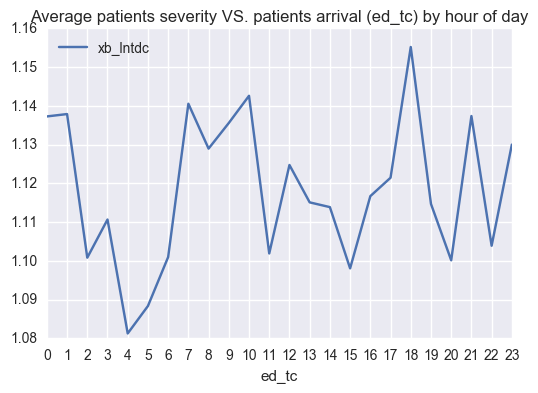

In [400]:
grouped = df[['ed_tc', 'xb_lntdc']].groupby(df['ed_tc'].dt.hour).mean()
grouped = grouped.reset_index()
grouped.plot(kind = 'line', x = 'ed_tc', y = 'xb_lntdc', xticks = range(24), title = 'Average patients severity VS. patients arrival (ed_tc) by hour of day')
#sns.pointplot(x="ed_tc", y="xb_lntdc", data=grouped, title = 'Patients severity VS. patients arrival by hour of day')

Although the pattern does seem cyclic, I wouldn't make further interpretation without consulting with a subject matter expert. To formally test whether the patient severity is predicted by the hour of the day, one could use Pearson's r. The following table shows there is not a significant correlation between the two variables, however, more investigation is needed in order to fully understand the nature of these variables. 

In [401]:
grouped.corr(method='pearson')

,ed_tc,xb_lntdc
ed_tc,1.000000,0.101848
xb_lntdc,0.101848,1.000000


### Part 3:
In this section we create a cesus data-set as described in part 3 of the questions.

The following function was written to create the census. It loops through indecis, and for each index that falls into the patient's stay period, it increments the index's value by one. This function uses vectorized operations to avoid expensive loops. 

Next, I create a boxplot to demonstrate the distribution of the number of patients under care over indecis.

One limitation of descrite time is that it condenses the variation throughout the hour into one variable. For example, if someone is admitted at 14:40 and is discharged at 15:01, both indecis corresponding to 14:00 and 15:00 would increment. The same would happen if those times were 14:00 and 15:59. This may cause inaccuracy when analyzing data.

In [402]:
def indexMaker():
    '''Creates indecis, increments when index falls into
    the patients stay'''
    index = -10 
    while index < 5:
        df[str(index)] = 0
        t = df['shift_start'] + timedelta(hours = index + 10)
        df.loc[(t <= df['dcord_tc']) & (t >= df['ed_tc']), str(index)] = 1
        index += 1
indexMaker()

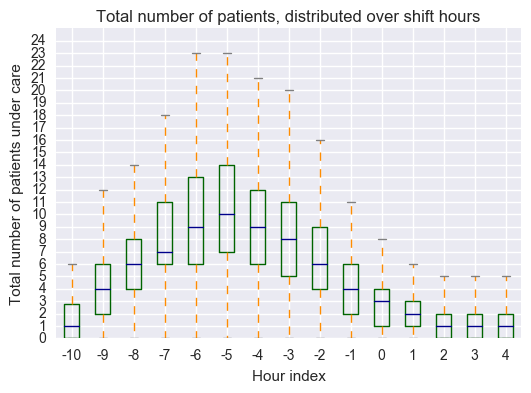

In [403]:
# group shiftids and aggregate hours:
census = df.groupby(['shiftid']).sum()
# drop unnecessary columns:
census.drop(['visit_num', 'xb_lntdc', 'stay'], axis=1, inplace=True)
# colors from here: http://pandas.pydata.org/
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
# boxplot for hours from beginning of the shift (-9) until 4 hours past the shift's end (+4)
bxplot = census.plot(kind='box', color=color, sym='r+', yticks = range(25))
bxplot.set_xlabel("Hour index")
bxplot.set_ylabel("Total number of patients under care")
bxplot.set_title("Total number of patients, distributed over shift hours")

As shown in the above figure, first there is an increase in number of patients under care. Then, it decreases as it gets closer to the end of shifts.

### Part 4.

Which physician appears to be the fastest at discharging patients?
Which variables do you control for?
What are potential threats (and any evidence of them) to your assessment? 

If the distribution of the "stay" variable was nomal, we could have just compared phsycians based on the mean of stay. But, there are other factors that could have an impact on the variable.

First, let's look at the mean of stay

In [404]:
df[['phys_name', 'stay']].groupby(df['phys_name']).mean().sort('stay').head()

# this result would be accurate if there was no other factors to control for

,stay
phys_name,
Diana,162.291096
Ronald,164.936709
Victoria,170.000000
Barack,180.477178
Woodrow,181.656977


Now, let's look at the distribution for a few variables to see if we can teak them.

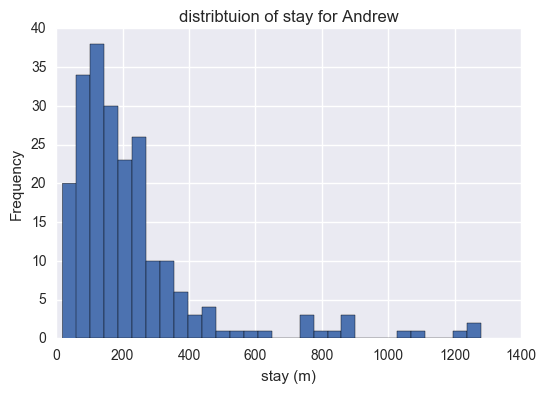

In [405]:
# distribution of stay for a random physician:
plot = df[df['phys_name']== 'Andrew']['stay'].plot(kind='hist', bins = 30)
plot.set_title('distribtuion of stay for Andrew')
plot.set_xlabel('stay (m)')

The above distribution looks right skewed. So, let's take the log:

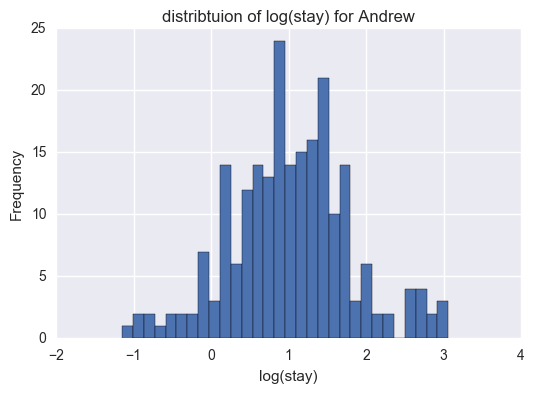

In [406]:
temp = p4_ctrl[p4_ctrl['phys_id']==1]
plot = temp['stay'].plot(kind='hist', bins = 30)
plot.set_title('distribtuion of log(stay) for Andrew')
plot.set_xlabel('log(stay)')

looks better. Now we have to control for patient's severity. Since xb_lntdc is the expected log length of stay, we need to treat that as a baseline and see how each datapoint differs from its corresponding expected value. 

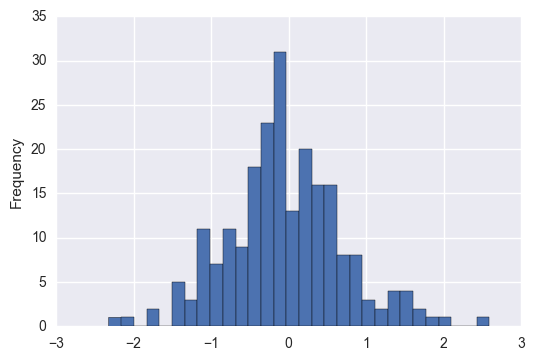

In [407]:
temp = p4_ctrl[p4_ctrl['phys_id']==1]
temp['DIFF'] = temp['stay'] - temp['xb_lntdc']
temp['DIFF'].plot(kind='hist', bins = 30)
plot.set_title('distribtuion of log(stay) for Andrew, corrected for patient severity')
plot.set_xlabel('log(stay) - log(E(stay))')

This looks like a good estimation for normal distribution, however other factors may play a role:
-- Number patients a phycisian has under care
-- Hour of day (we showed that patients severity varies with hour of day)
-- Hour of shift (one can assume that a physician's performance decreases near the end of shift)

In [408]:
# tot_patients: number of patients that were assigned to each physican in a shift
df_grouped = pd.DataFrame(df.groupby(['shiftid', 'phys_name']).size(), columns = ['tot_patients'])

# join it back to df and create dataframe
df_corr = pd.merge(df[['shiftid', 'shift_start', 'phys_name', 'xb_lntdc', 'stay']]
                  , df_grouped, how='inner', right_index = True, left_on = ['shiftid', 'phys_name'])

# create a new variable: the hour at which the shift started
df_corr['shift_start_h'] = df_corr['shift_start'].dt.hour

# take a look
df_corr.head()

,shiftid,shift_start,phys_name,xb_lntdc,stay,tot_patients,shift_start_h
0,17may1982 1 p.m. to 10 p.m.,1982-05-17 13:00:00,Andrew,0.408644,1202.0,17,13
42,17may1982 1 p.m. to 10 p.m.,1982-05-17 13:00:00,Andrew,1.063751,81.0,17,13
86,17may1982 1 p.m. to 10 p.m.,1982-05-17 13:00:00,Andrew,1.825766,134.0,17,13
91,17may1982 1 p.m. to 10 p.m.,1982-05-17 13:00:00,Andrew,1.341938,183.0,17,13
108,17may1982 1 p.m. to 10 p.m.,1982-05-17 13:00:00,Andrew,1.071335,371.0,17,13


In [409]:
# Now let's take a look at correlations using Pearson's R
df_corr.corr(method = 'pearson')

,xb_lntdc,stay,tot_patients,shift_start_h
xb_lntdc,1.000000,0.282449,-0.048528,0.040018
stay,0.282449,1.000000,-0.049420,0.054600
tot_patients,-0.048528,-0.049420,1.000000,0.214021
shift_start_h,0.040018,0.054600,0.214021,1.000000


As shown above, the strongest correlation is between stay and patient's severity, which makes sense. In the next step, we will control for this effect.

Given the correlation and above histograms, we can define the corrected stay as log of stay relative to the expected value:
rel_stay = log(stay) - log(E(stay))

In [410]:
# create a dataframe (ctrl for controlled)
p4_ctrl = pd.DataFrame(df[['phys_name', 'ed_tc', 'dcord_tc', 'visit_num', 'xb_lntdc', 'shift_start', 'shiftid']])

# same processing as above
# create a variable, "stay": the time period between the patient's arrival and discharge
p4_ctrl['stay'] = p4_ctrl['dcord_tc'] - p4_ctrl['ed_tc']

# convert to timedelta format
p4_ctrl['stay'] = pd.to_timedelta(p4_ctrl['stay'])

# convert to minutes
p4_ctrl['stay'] = p4_ctrl['stay']/np.timedelta64(1, 'h')

# log length of stay
p4_ctrl['stay'] = np.log(p4_ctrl['stay'])

# create phys_id for convenient grouping
p4_ctrl['phys_name'] = p4_ctrl['phys_name'].astype('category')
p4_ctrl['phys_id'] = p4_ctrl['phys_name'].cat.codes

p4_ctrl['rel_stay'] = p4_ctrl['stay'] - p4_ctrl['xb_lntdc']
# correlations
p4_ctrl.corr(method = 'pearson')

# Note that the correlation between the patient severity and log stay is even stronger than before taking the log

,visit_num,xb_lntdc,stay,phys_id,rel_stay
visit_num,1.000000,0.004969,0.017374,0.068012,0.016630
xb_lntdc,0.004969,1.000000,0.431459,0.016735,-0.047068
stay,0.017374,0.431459,1.000000,-0.029378,0.880825
phys_id,0.068012,0.016735,-0.029378,1.000000,-0.041312
rel_stay,0.016630,-0.047068,0.880825,-0.041312,1.000000


The following charts demonstrate variations of stay and rel_stay with patient's severity for each physician.
Note: Victoria has only 2 datapoints. Thus, we should be careful when determining who's fastest.

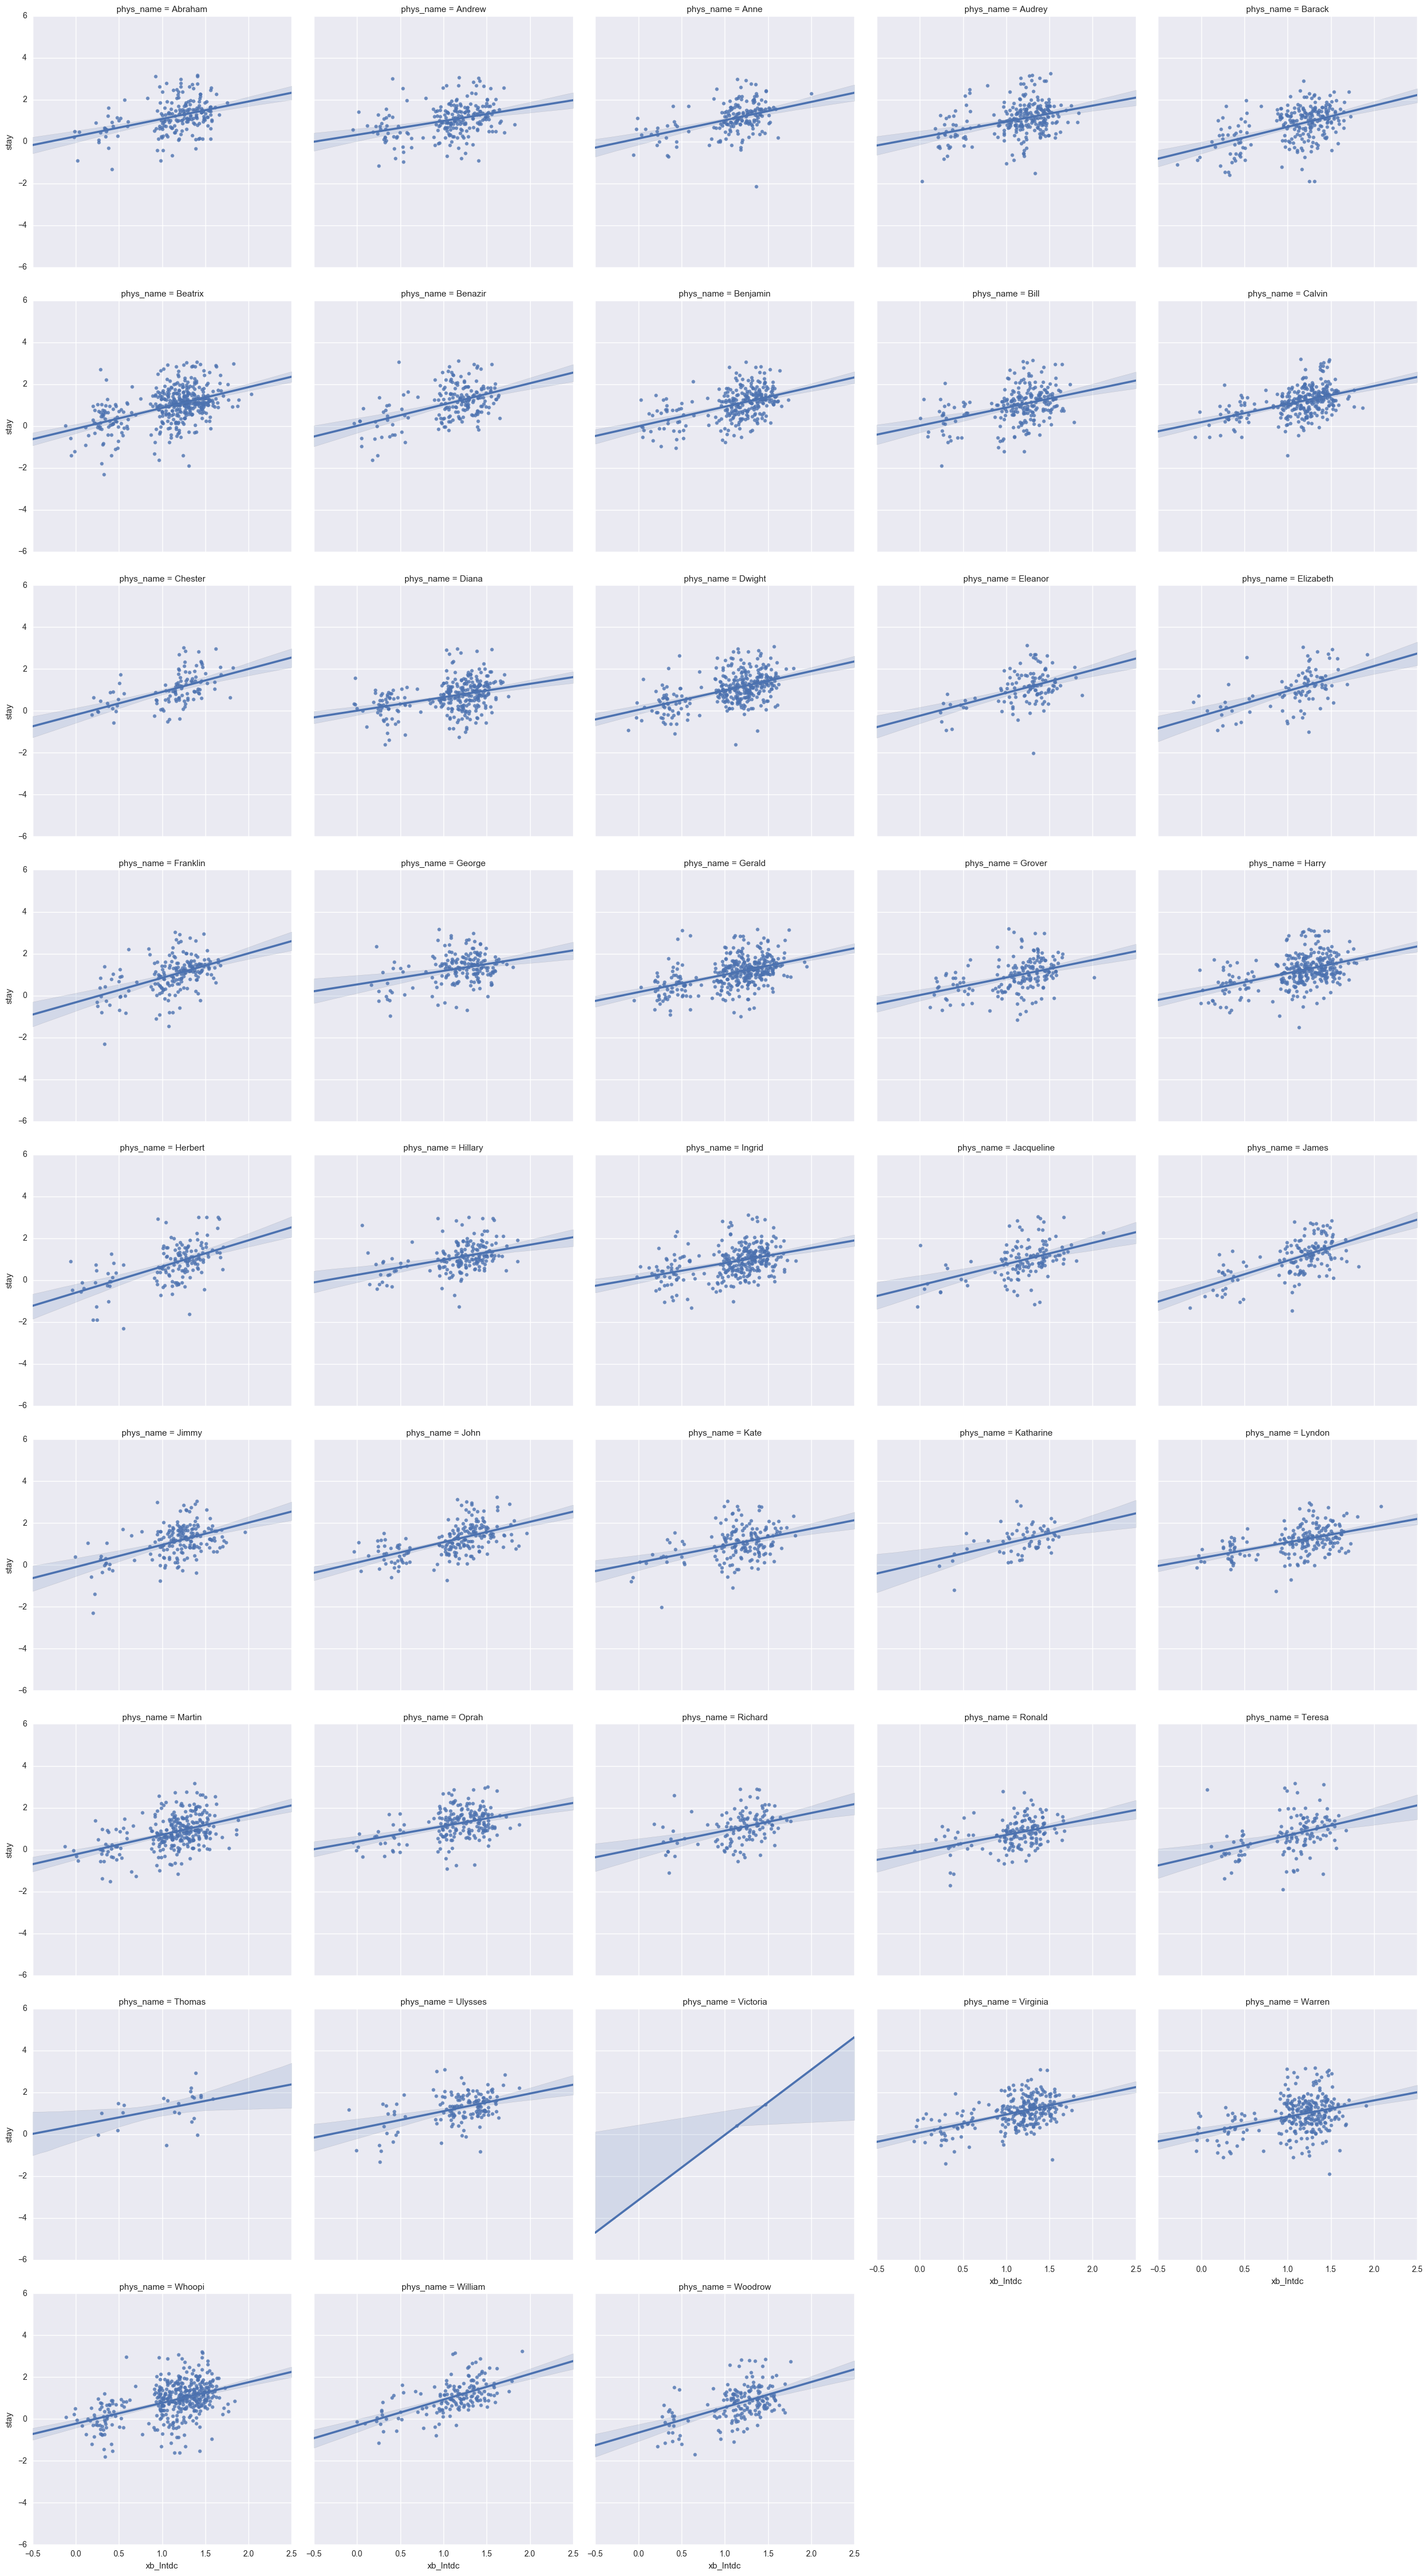

In [411]:
p = sns.lmplot(x="xb_lntdc", y="stay", col="phys_name", data=p4_ctrl,
           col_wrap=5)

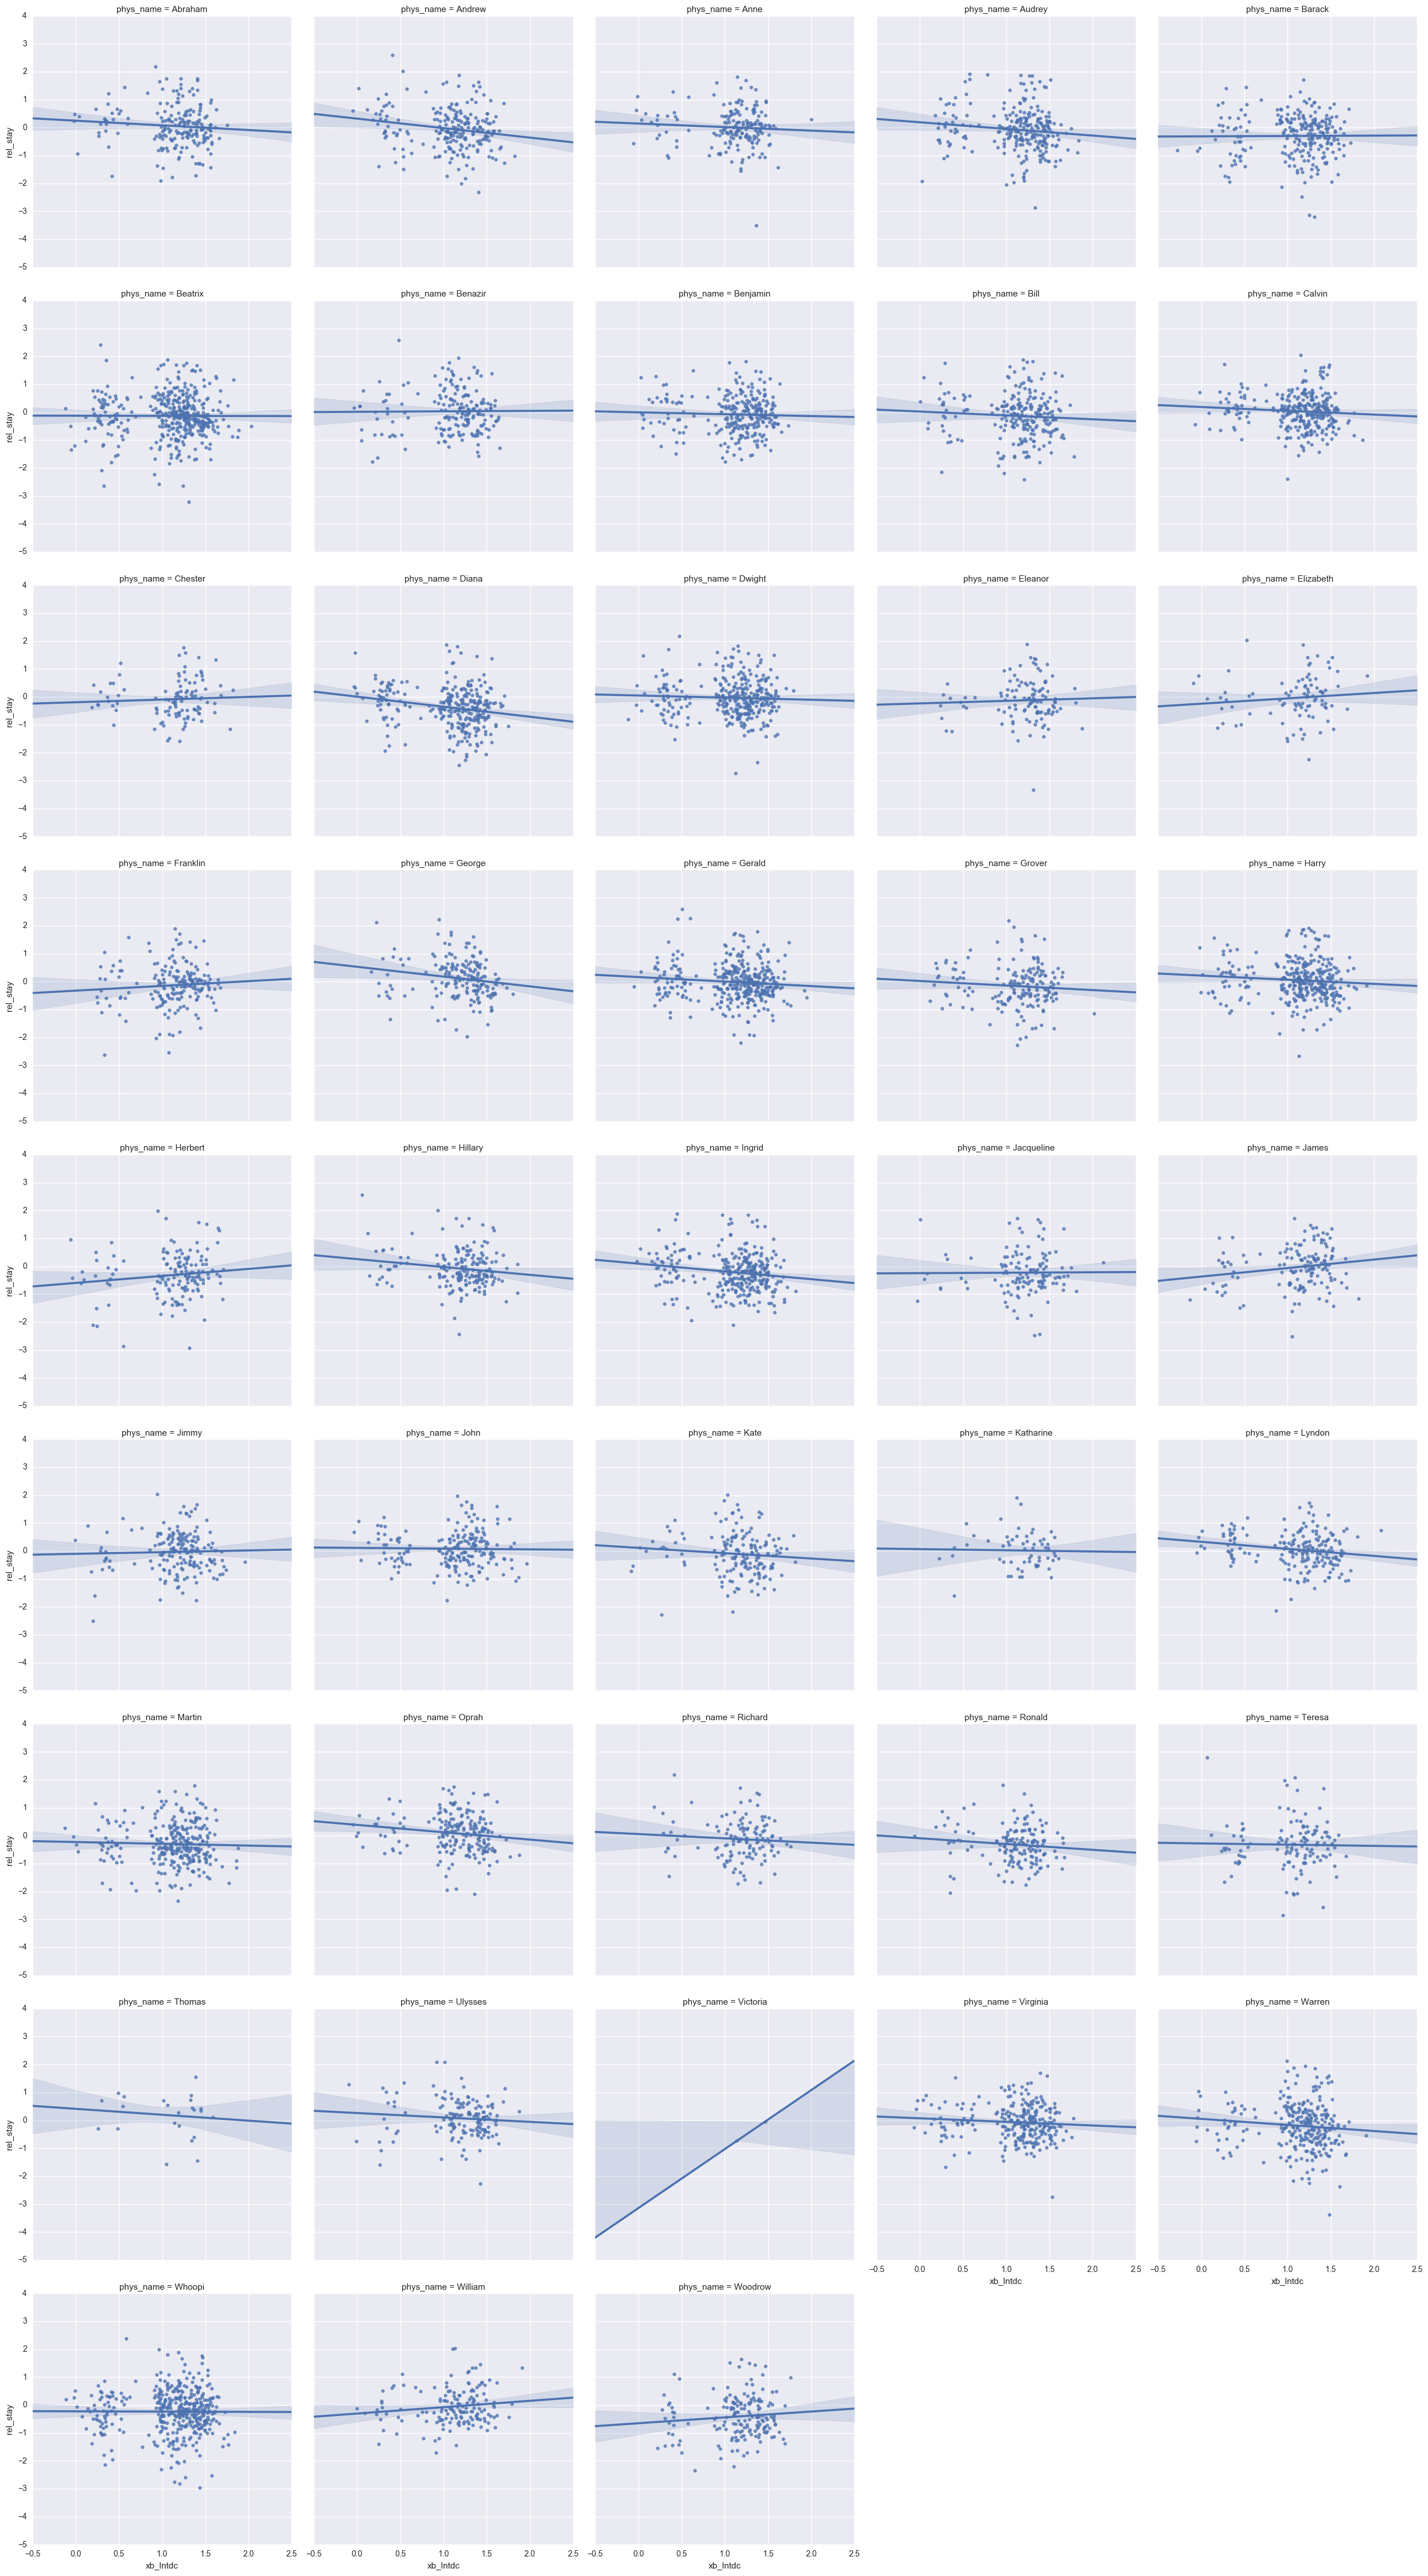

In [412]:
p = sns.lmplot(x="xb_lntdc", y="rel_stay", col="phys_name", data=p4_ctrl,
           col_wrap=5)

As shown in the following figure, the distributions look closer to a normal distribution.

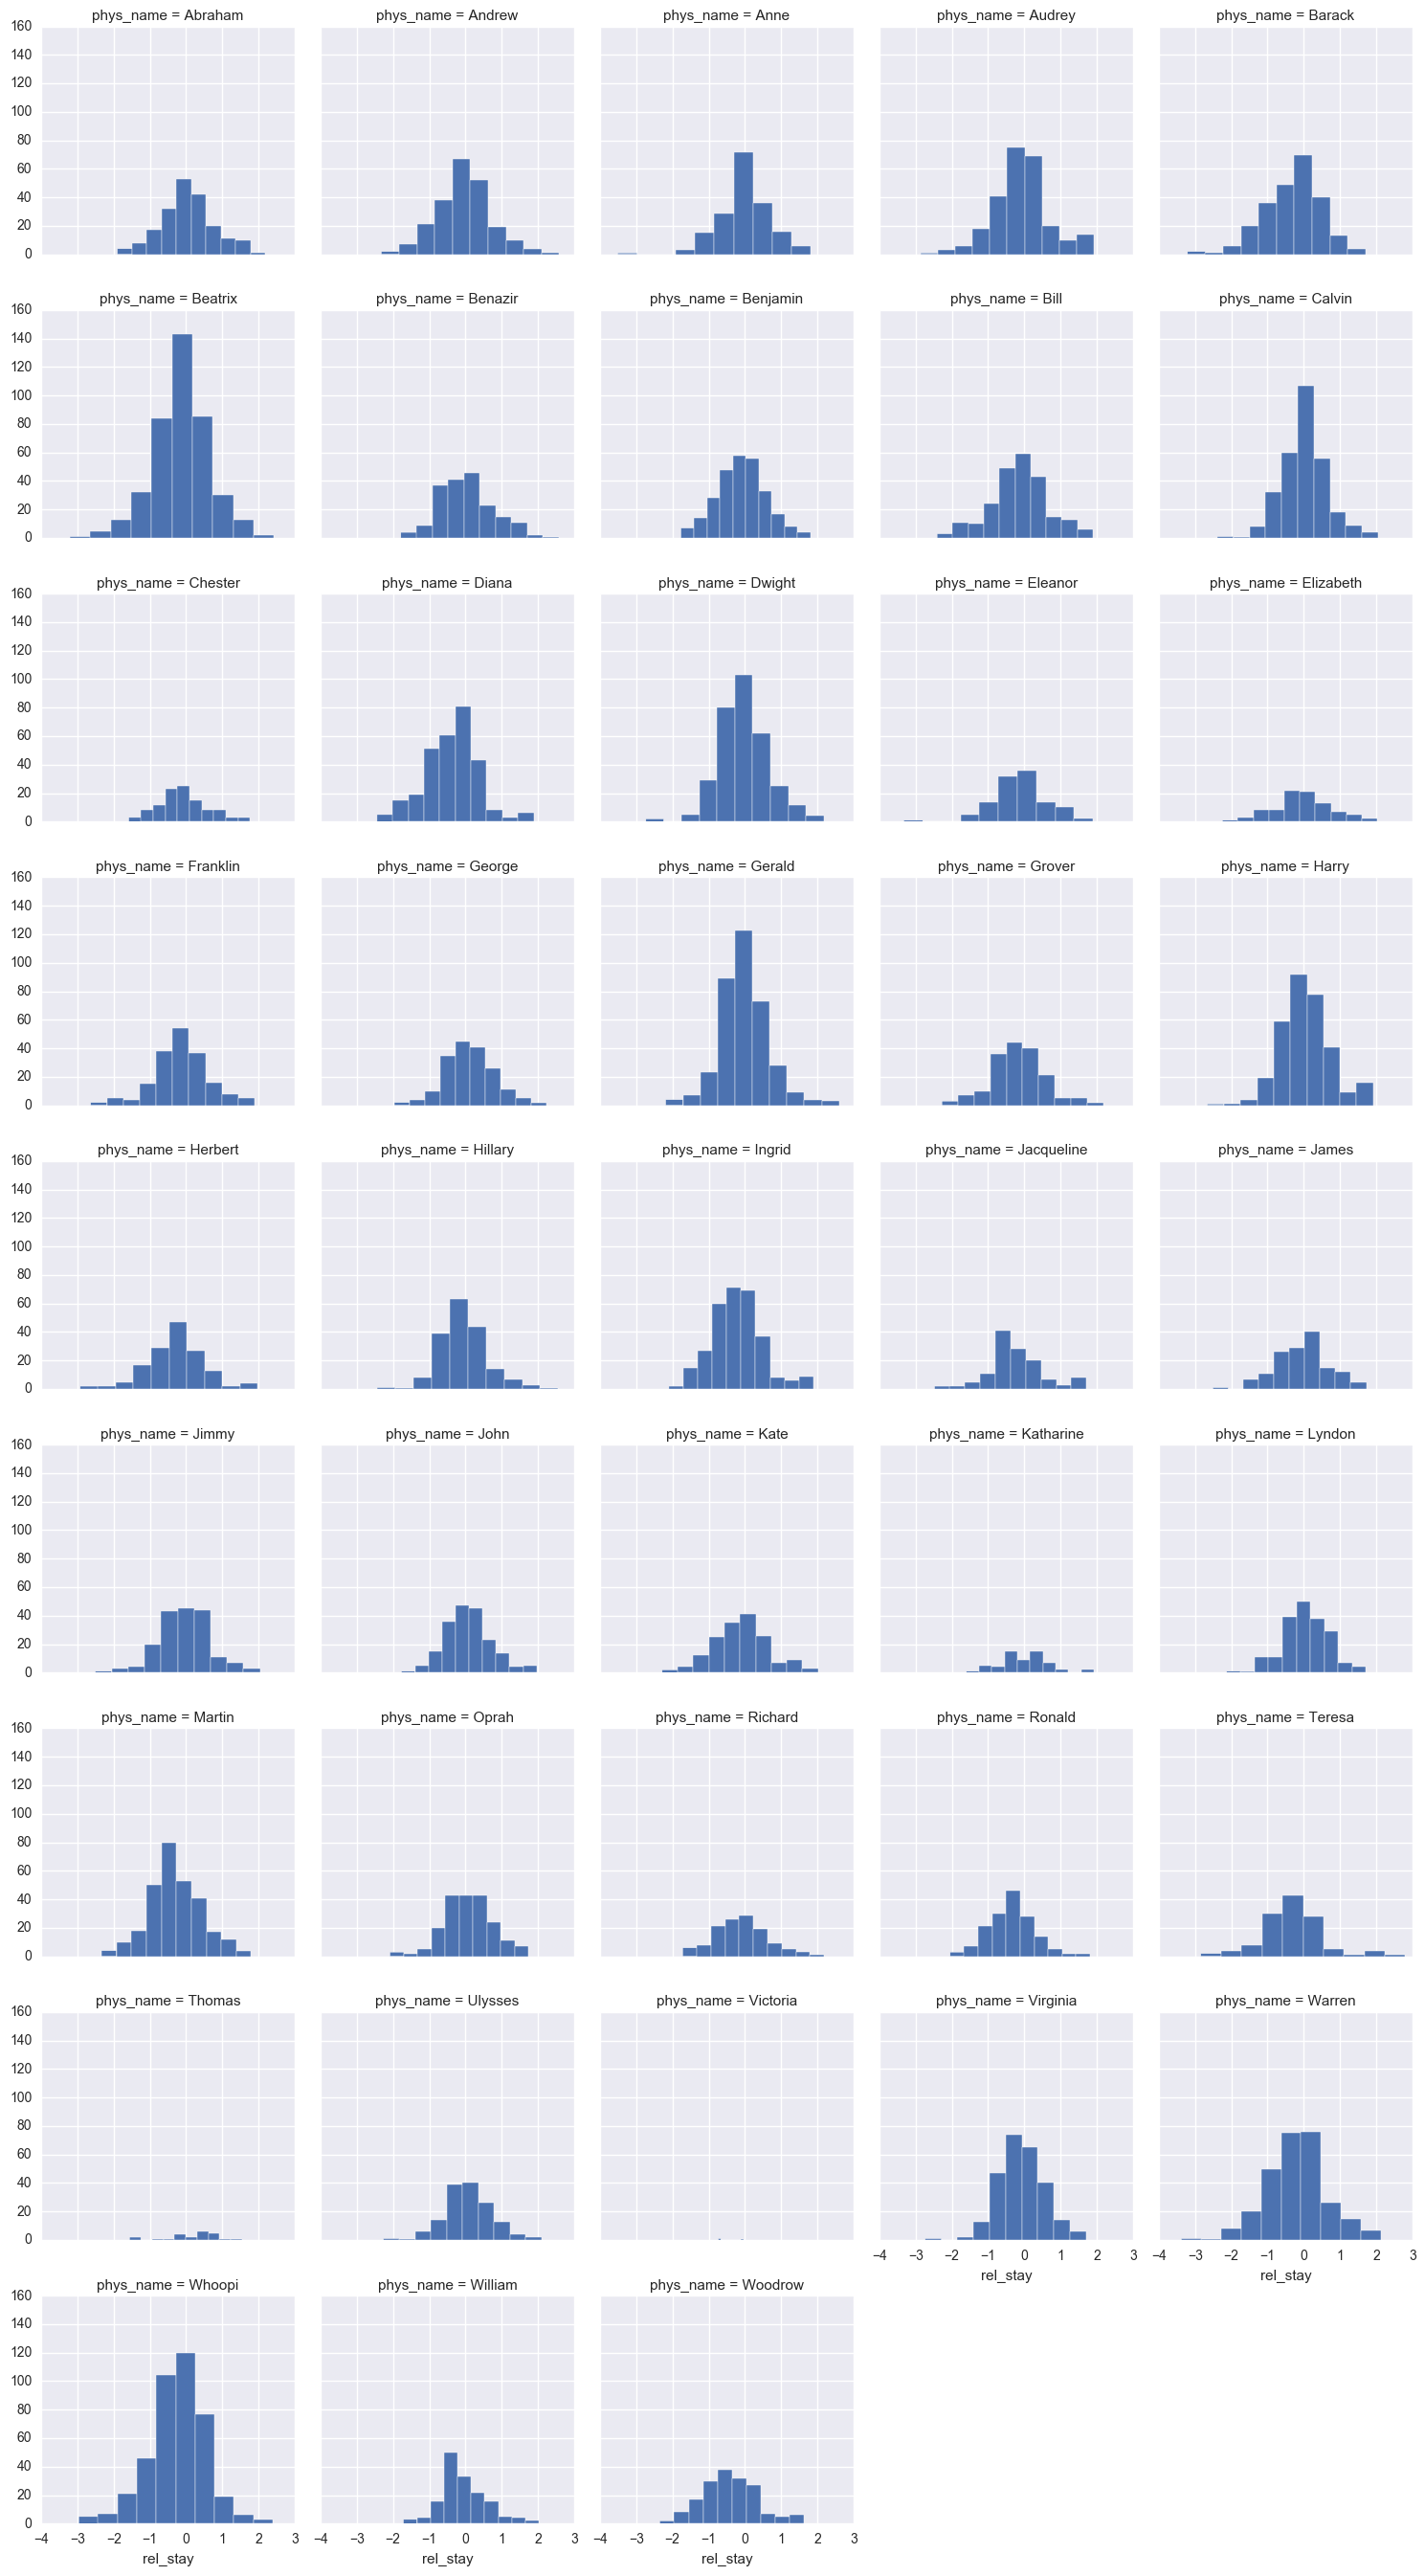

In [413]:
g = sns.FacetGrid(p4_ctrl, col="phys_name", col_wrap=5)
g = g.map(plt.hist, "rel_stay", edgecolor="w")

The following boxplot also gives a good understanding of the distributions

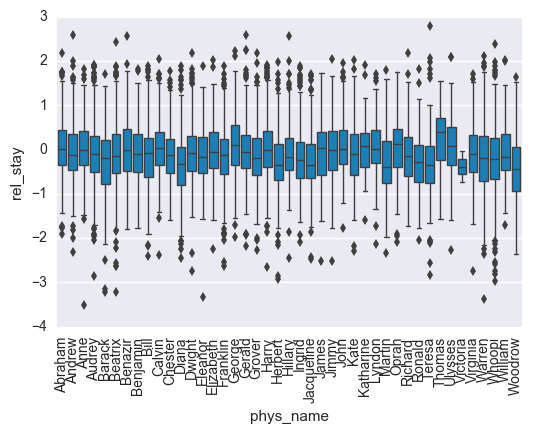

In [414]:
# data frame for the boxplot 
p4_ctrl_bxplt = p4_ctrl[['phys_name', 'rel_stay']]

# plot
ax = sns.boxplot(x="phys_name", y="rel_stay", data=p4_ctrl_bxplt, linewidth=1,  color="#0288D1")
ax = plt.xticks(rotation='vertical')

Now, we can look at the mean, median, and standard deviation:

In [415]:
grouped = p4_ctrl.groupby(p4_ctrl['phys_name'])

In [416]:
# median, mean, std
#grouped['rel_stay'].agg([np.median, np.mean, np.std]).sort('mean')

# look at the 5 fastest
grouped['rel_stay'].agg([np.median, np.mean, np.std]).sort('mean').head()

,median,mean,std
phys_name,,,
Woodrow,-0.445566,-0.411756,0.750046
Victoria,-0.387677,-0.387677,0.490327
Diana,-0.328145,-0.380408,0.719384
Teresa,-0.341880,-0.324588,0.865838
Ronald,-0.278551,-0.320370,0.644246


In [417]:
# more thorough description:
#grouped.describe()

The above table lists the five fastes physicians. However, we need to take into consideration other factors (such as the ones mentioned earlier) that may play a role. One potential approach is to perform a PCA to discover the inter-relationship of different variables. Our assumption was that rel_stay is normally distributed. This needs to be tested.